In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr

from ufs2arco import sources
from ufs2arco.transforms.horizontal_regrid import get_bounds

### Get the coarsened HRRR data at 6km x 6km

In [2]:
cds = xr.open_dataset("/pscratch/sd/t/timothys/nested-eagle/v1/data/hrrr_06km.nc")

In [3]:
cds

<xarray.Dataset> Size: 15MB
Dimensions:  (y: 529, x: 899, y_b: 530, x_b: 900)
Coordinates:
    lat      (y, x) float64 4MB ...
    lon      (y, x) float64 4MB ...
    lat_b    (y_b, x_b) float64 4MB ...
    lon_b    (y_b, x_b) float64 4MB ...
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*

In [5]:
trim = 25
nmc = 2
tcds = cds.isel(
    x=slice(trim, -trim-1),
    y=slice(trim, -trim-1),
    x_b=slice(trim, -trim-1),
    y_b=slice(trim, -trim-1),
)
print(len(tcds.x)/nmc)
print(len(tcds.y)/nmc)
print(tcds.lon.isel(x=0,y=0).values, tcds.lat.isel(x=0,y=0).values)
print(tcds.lon.isel(x=-1,y=-1).values, tcds.lat.isel(x=-1,y=-1).values)

424.0
239.0
238.26651186390794 22.74828875324142
296.34063128396434 47.05228010849829


In [6]:
print(len(cds.x), len(tcds.x))
print(len(cds.y), len(tcds.y))
print(len(cds.x_b), len(tcds.x_b))
print(len(cds.y_b), len(tcds.y_b))

899 848
529 478
900 849
530 479


So... no idea how this generalizes beyond a factor of 2 (nmc=2 in the code). But, this looks good for a first stab.

In [8]:
center_idx_x = cds.x_b.values[slice(trim+1, -trim-1, nmc)]
center_idx_y = cds.y_b.values[slice(trim+1, -trim-1, nmc)]

In [9]:
# This makes 
hmesh = cds[["lat_b", "lon_b"]].isel(
    x_b=slice(trim-1, -trim, nmc),
    y_b=slice(trim-1, -trim, nmc),
).rename(
    {"lat_b": "lat", "lon_b": "lon", "x_b": "x", "y_b": "y"},
)

Double check myself.

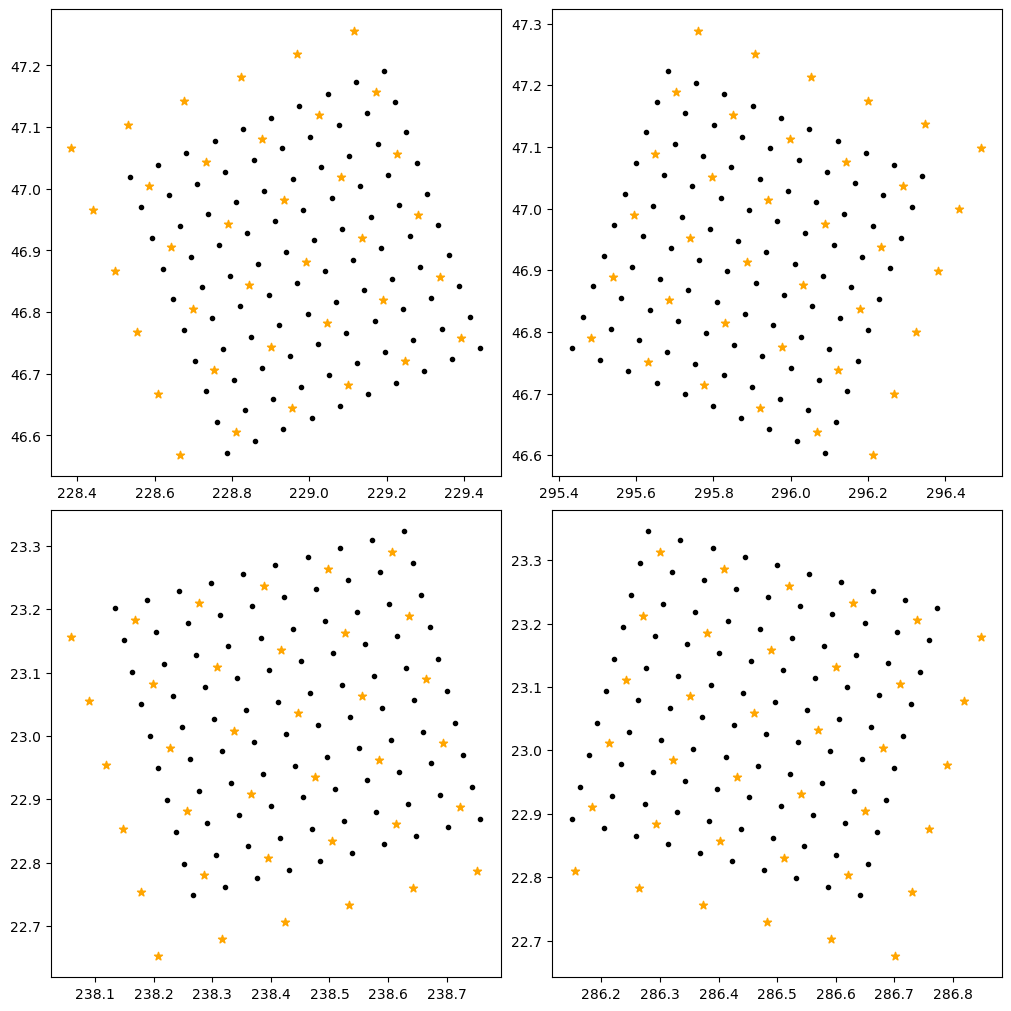

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10,10), constrained_layout=True)

for slc, slc_b, ax in zip(
    [
        {"x": slice(10), "y": slice(-10, None)},
        {"x": slice(-10, None), "y": slice(-10, None)},
        {"x": slice(10), "y": slice(10)},
        {"x": slice(-10, None), "y": slice(10)},
    ],
    [
        {"x": slice(6), "y": slice(-6, None)},
        {"x": slice(-6, None), "y": slice(-6, None)},
        {"x": slice(6), "y": slice(6)},
        {"x": slice(-6, None), "y": slice(6)},
    ],
    axs.flatten(),
):
    ax.scatter(tcds.lon.isel(**slc), tcds.lat.isel(**slc), c="black", marker=".")
    ax.scatter(hmesh.lon.isel(**slc_b), hmesh.lat.isel(**slc_b), c="orange", marker="*")

### Store it as nc, combined with global in separate notebook

In [12]:
hmesh.to_netcdf(f"latentx2.spongex1.hrrr06km.trim25-26.nc")